In [1]:
USER_FLAG = "--user"

In [2]:
%pip install $USER_FLAG google-cloud-aiplatform==1.59.0
%pip install $USER_FLAG kfp google-cloud-pipeline-components==0.1.1 --upgrade
%pip uninstall -y shapely pygeos geopandas
%pip install shapely==1.8.5.post1 pygeos==0.12.0 geopandas>=0.12.2
%pip install google-cloud-pipeline-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 37.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.9 MB/s eta 0:00:00
  DEPRECATION: Building 'kfp' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'kfp'. Discussion can be found at https://githu

In [3]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [1]:
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
!python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

KFP SDK version: 1.8.22
google_cloud_pipeline_components version: 0.1.1


### 2단계: 프로젝트 ID 및 버킷 설정하기
이 실습 전체에서 Cloud 프로젝트 ID와 이전에 만든 버킷을 참조합니다. 다음으로는 이들 각각의 변수를 만듭니다.

In [2]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  qwiklabs-gcp-03-994d160ad691


In [3]:
BUCKET_NAME="gs://" + PROJECT_ID + "-labconfig-bucket"

### 3단계: 라이브러리 가져오기

In [4]:
from typing import NamedTuple

import kfp
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, ClassificationMetrics, Metrics, component)
from kfp.v2.google.client import AIPlatformClient

from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip

### 4단계: 상수 정의하기

In [5]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="us-central1"


PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


'gs://qwiklabs-gcp-03-994d160ad691-labconfig-bucket/pipeline_root/'

# 작업 3. 첫 번째 파이프라인 만들기

In [6]:
@component(base_image="python:3.9", output_component_file="first-component.yaml")
def product_name(text: str) -> str:
    return text

In [7]:
product_name_component = kfp.components.load_component_from_file('./first-component.yaml')

In [8]:
@component(base_image="python:3.9", output_component_file="second-component.yaml", packages_to_install=["emoji"])
def emoji(
    text: str,
) -> NamedTuple(
    "Outputs",
    [
        ("emoji_text", str),  # Return parameters
        ("emoji", str),
    ],
):
    import emoji

    emoji_text = text
    emoji_str = emoji.emojize(':' + emoji_text + ':', language='alias')
    print("output one: {}; output_two: {}".format(emoji_text, emoji_str))
    return (emoji_text, emoji_str)

In [9]:
@component(base_image="python:3.9", output_component_file="third-component.yaml")
def build_sentence(
    product: str,
    emoji: str,
    emojitext: str
) -> str:
    print("We completed the pipeline, hooray!")
    end_str = product + " is "
    if len(emoji) > 0:
        end_str += emoji
    else:
        end_str += emojitext
    return(end_str)

In [10]:
@dsl.pipeline(
    name="hello-world",
    description="An intro pipeline",
    pipeline_root=PIPELINE_ROOT,
)

# You can change the `text` and `emoji_str` parameters here to update the pipeline output
def intro_pipeline(text: str = "Vertex AI Pipelines", emoji_str: str = "sparkles"):
    product_task = product_name(text)
    emoji_task = emoji(emoji_str)
    consumer_task = build_sentence(
        product_task.output,
        emoji_task.outputs["emoji"],
        emoji_task.outputs["emoji_text"],
    )

In [11]:
compiler.Compiler().compile(
    pipeline_func=intro_pipeline, package_path="intro_pipeline_job.json"
)

/home/jupyter/.local/lib/python3.10/site-packages/kfp/v2/compiler/compiler.py:1290: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  warnings.warn(


In [12]:
api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

/home/jupyter/.local/lib/python3.10/site-packages/kfp/v2/google/client/client.py:169: FutureWarning: AIPlatformClient will be deprecated in v2.0.0. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  warnings.warn(


In [13]:
response = api_client.create_run_from_job_spec(
    job_spec_path="intro_pipeline_job.json",
    # pipeline_root=PIPELINE_ROOT  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
)

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


# 작업 4. 엔드 투 엔드 ML 파이프라인 만들기

In [14]:
@component(
    base_image="gcr.io/deeplearning-platform-release/tf2-cpu.2-3:latest",
    output_component_file="tables_eval_component.yaml", # Optional: you can use this to load the component later
    packages_to_install=["google-cloud-aiplatform"],
)
def classif_model_eval_metrics(
    project: str,
    location: str,  # "region",
    api_endpoint: str,  # "region-aiplatform.googleapis.com",
    thresholds_dict_str: str,
    model: Input[Model],
    metrics: Output[Metrics],
    metricsc: Output[ClassificationMetrics],
) -> NamedTuple("Outputs", [("dep_decision", str)]):  # Return parameter.

    """This function renders evaluation metrics for an AutoML Tabular classification model.
    It retrieves the classification model evaluation generated by the AutoML Tabular training
    process, does some parsing, and uses that info to render the ROC curve and confusion matrix
    for the model. It also uses given metrics threshold information and compares that to the
    evaluation results to determine whether the model is sufficiently accurate to deploy.
    """
    import json
    import logging

    from google.cloud import aiplatform

    # Fetch model eval info
    def get_eval_info(client, model_name):
        from google.protobuf.json_format import MessageToDict

        response = client.list_model_evaluations(parent=model_name)
        metrics_list = []
        metrics_string_list = []
        for evaluation in response:
            print("model_evaluation")
            print(" name:", evaluation.name)
            print(" metrics_schema_uri:", evaluation.metrics_schema_uri)
            metrics = MessageToDict(evaluation._pb.metrics)
            for metric in metrics.keys():
                logging.info("metric: %s, value: %s", metric, metrics[metric])
            metrics_str = json.dumps(metrics)
            metrics_list.append(metrics)
            metrics_string_list.append(metrics_str)

        return (
            evaluation.name,
            metrics_list,
            metrics_string_list,
        )

    # Use the given metrics threshold(s) to determine whether the model is
    # accurate enough to deploy.
    def classification_thresholds_check(metrics_dict, thresholds_dict):
        for k, v in thresholds_dict.items():
            logging.info("k {}, v {}".format(k, v))
            if k in ["auRoc", "auPrc"]:  # higher is better
                if metrics_dict[k] < v:  # if under threshold, don't deploy
                    logging.info(
                        "{} < {}; returning False".format(metrics_dict[k], v)
                    )
                    return False
        logging.info("threshold checks passed.")
        return True

    def log_metrics(metrics_list, metricsc):
        test_confusion_matrix = metrics_list[0]["confusionMatrix"]
        logging.info("rows: %s", test_confusion_matrix["rows"])

        # log the ROC curve
        fpr = []
        tpr = []
        thresholds = []
        for item in metrics_list[0]["confidenceMetrics"]:
            fpr.append(item.get("falsePositiveRate", 0.0))
            tpr.append(item.get("recall", 0.0))
            thresholds.append(item.get("confidenceThreshold", 0.0))
        print(f"fpr: {fpr}")
        print(f"tpr: {tpr}")
        print(f"thresholds: {thresholds}")
        metricsc.log_roc_curve(fpr, tpr, thresholds)

        # log the confusion matrix
        annotations = []
        for item in test_confusion_matrix["annotationSpecs"]:
            annotations.append(item["displayName"])
        logging.info("confusion matrix annotations: %s", annotations)
        metricsc.log_confusion_matrix(
            annotations,
            test_confusion_matrix["rows"],
        )

        # log textual metrics info as well
        for metric in metrics_list[0].keys():
            if metric != "confidenceMetrics":
                val_string = json.dumps(metrics_list[0][metric])
                metrics.log_metric(metric, val_string)
        # metrics.metadata["model_type"] = "AutoML Tabular classification"

    logging.getLogger().setLevel(logging.INFO)
    aiplatform.init(project=project)
    # extract the model resource name from the input Model Artifact
    model_resource_path = model.uri.replace("aiplatform://v1/", "")
    logging.info("model path: %s", model_resource_path)

    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    eval_name, metrics_list, metrics_str_list = get_eval_info(
        client, model_resource_path
    )
    logging.info("got evaluation name: %s", eval_name)
    logging.info("got metrics list: %s", metrics_list)
    log_metrics(metrics_list, metricsc)

    thresholds_dict = json.loads(thresholds_dict_str)
    deploy = classification_thresholds_check(metrics_list[0], thresholds_dict)
    if deploy:
        dep_decision = "true"
    else:
        dep_decision = "false"
    logging.info("deployment decision is %s", dep_decision)

    return (dep_decision,)

In [15]:
import time
DISPLAY_NAME = 'automl-beans{}'.format(str(int(time.time())))
print(DISPLAY_NAME)

automl-beans1749792381


In [16]:
@kfp.dsl.pipeline(name="automl-tab-beans-training-v2",
                  pipeline_root=PIPELINE_ROOT)
def pipeline(
    bq_source: str = "bq://aju-dev-demos.beans.beans1",
    display_name: str = DISPLAY_NAME,
    project: str = PROJECT_ID,
    gcp_region: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
    thresholds_dict_str: str = '{"auRoc": 0.95}',
):
    dataset_create_op = gcc_aip.TabularDatasetCreateOp(
        project=project, display_name=display_name, bq_source=bq_source
    )

    training_op = gcc_aip.AutoMLTabularTrainingJobRunOp(
        project=project,
        display_name=display_name,
        optimization_prediction_type="classification",
        budget_milli_node_hours=1000,
        column_transformations=[
            {"numeric": {"column_name": "Area"}},
            {"numeric": {"column_name": "Perimeter"}},
            {"numeric": {"column_name": "MajorAxisLength"}},
            {"numeric": {"column_name": "MinorAxisLength"}},
            {"numeric": {"column_name": "AspectRation"}},
            {"numeric": {"column_name": "Eccentricity"}},
            {"numeric": {"column_name": "ConvexArea"}},
            {"numeric": {"column_name": "EquivDiameter"}},
            {"numeric": {"column_name": "Extent"}},
            {"numeric": {"column_name": "Solidity"}},
            {"numeric": {"column_name": "roundness"}},
            {"numeric": {"column_name": "Compactness"}},
            {"numeric": {"column_name": "ShapeFactor1"}},
            {"numeric": {"column_name": "ShapeFactor2"}},
            {"numeric": {"column_name": "ShapeFactor3"}},
            {"numeric": {"column_name": "ShapeFactor4"}},
            {"categorical": {"column_name": "Class"}},
        ],
        dataset=dataset_create_op.outputs["dataset"],
        target_column="Class",
    )
    model_eval_task = classif_model_eval_metrics(
        project,
        gcp_region,
        api_endpoint,
        thresholds_dict_str,
        training_op.outputs["model"],
    )

    with dsl.Condition(
        model_eval_task.outputs["dep_decision"] == "true",
        name="deploy_decision",
    ):

        deploy_op = gcc_aip.ModelDeployOp(  # noqa: F841
            model=training_op.outputs["model"],
            project=project,
            machine_type="e2-standard-4",
        )

In [17]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="tab_classif_pipeline.json"
)

In [18]:
response = api_client.create_run_from_job_spec(
    "tab_classif_pipeline.json", pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID,"display_name": DISPLAY_NAME}
)

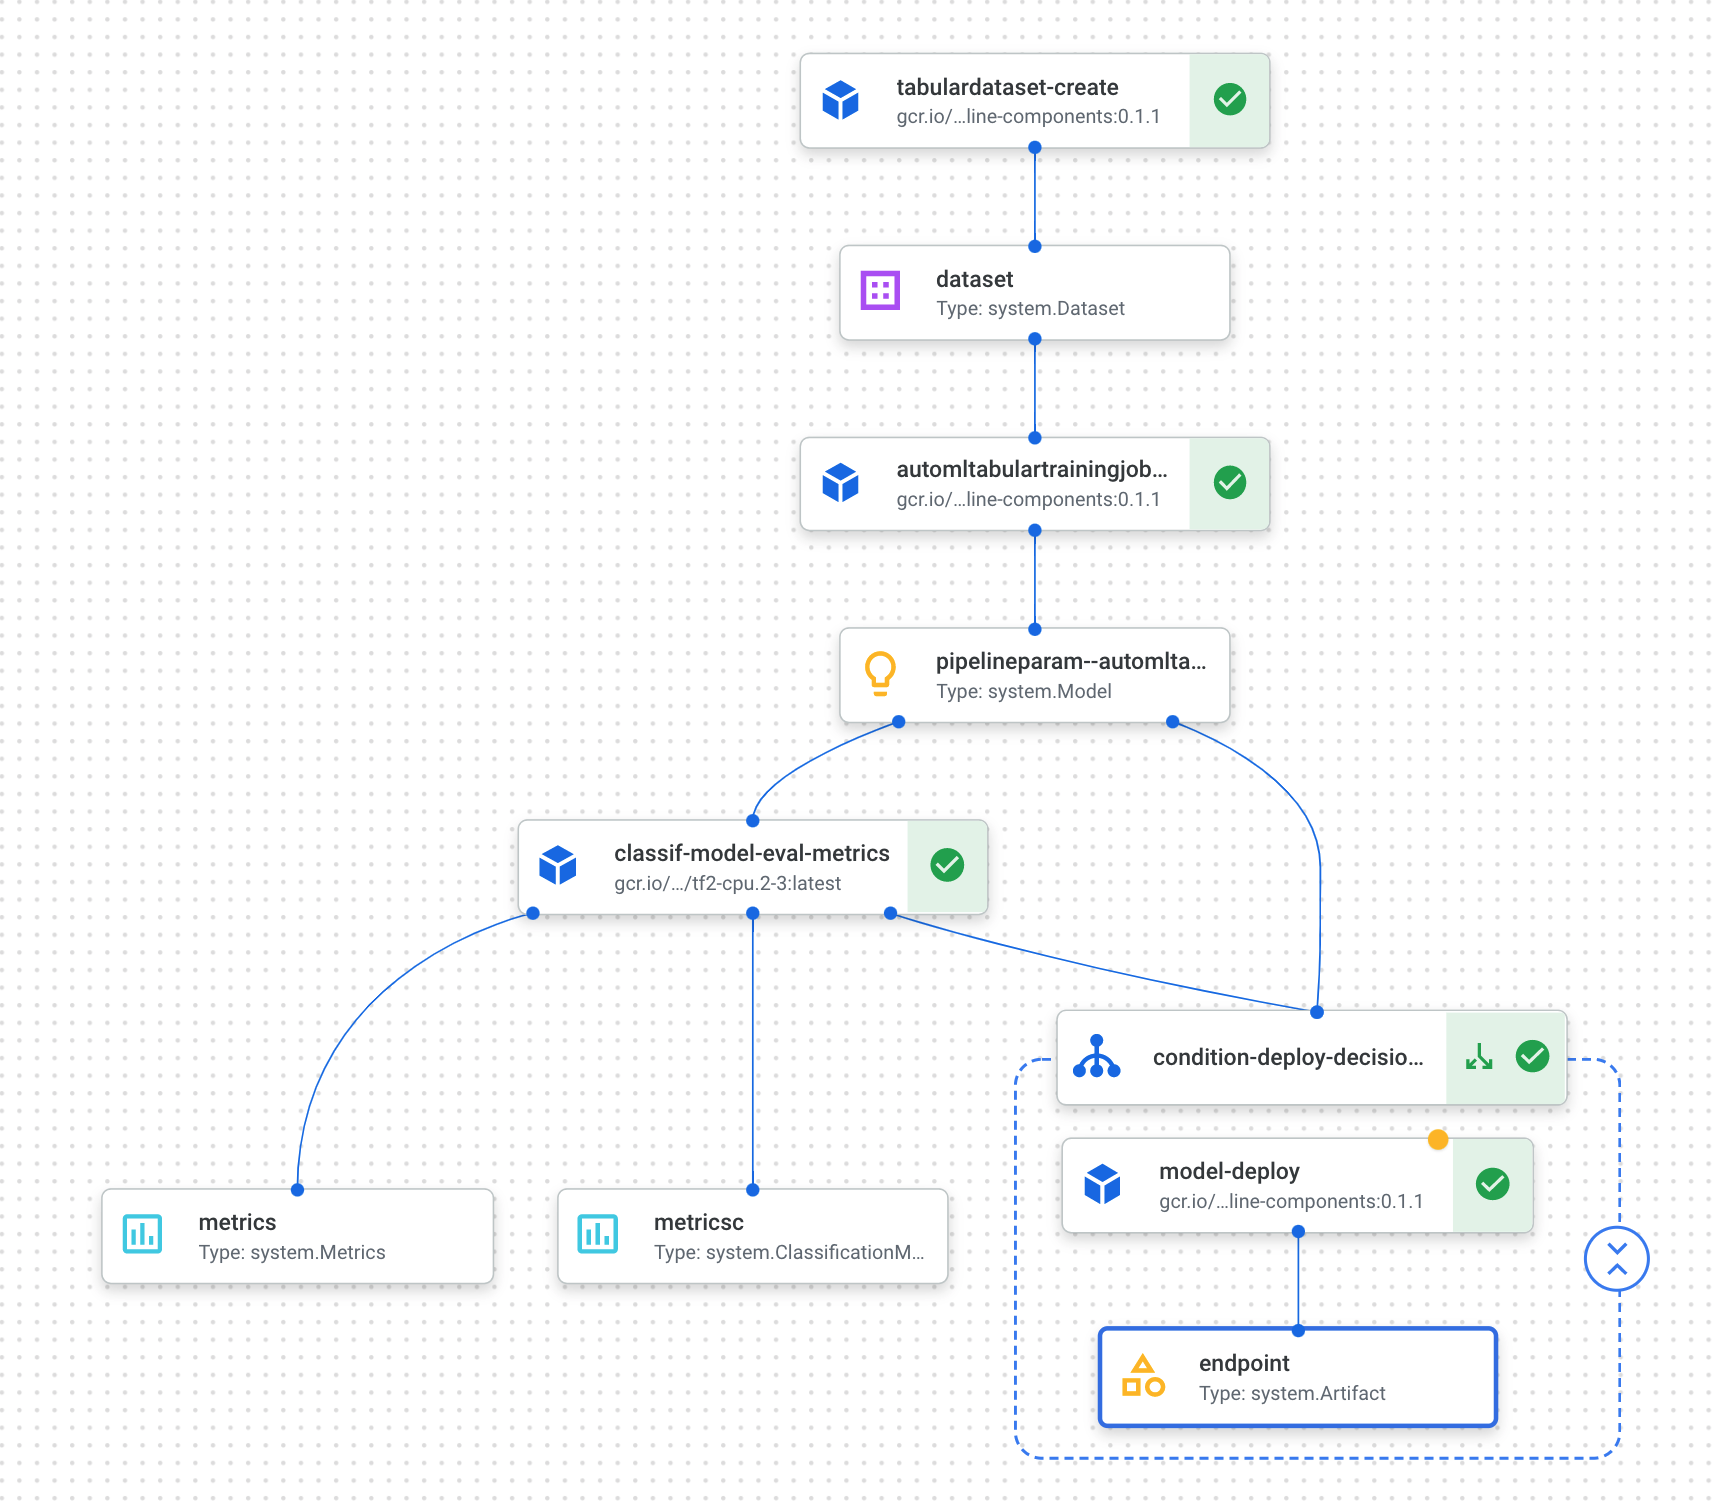